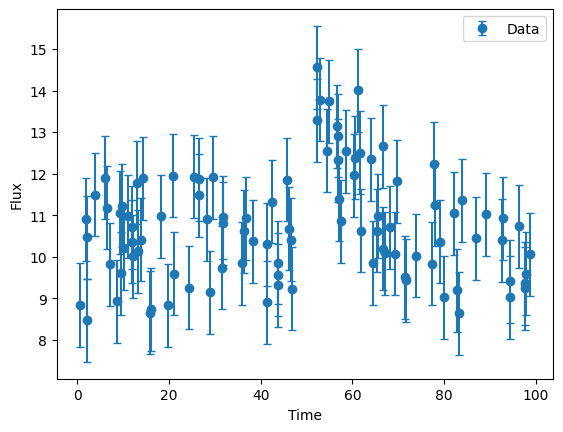

In [15]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")

time_data, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time_data, flux, yerr=err, fmt='o', label='Data', capsize=3)
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [ ]:
def model(t, theta ):
    C, A, alpha, t0 = theta
    return np.where(t < t0,                                     # for t < t0
                    C,                                          # costant
                    C + A * np.exp(- alpha *(t - t0)))          # else , exp  function 


def loglikelihood (f , y , sigma):
    L = 1
    for i in range(len(flux)):
        L *= (1/(np.sqrt(2*np.pi) * sigma)) * np.exp(-((f[i]-y[i])/(np.sqrt(2)*sigma))**2)
    return np.log(L)


#This represents your belief about the parameters before seeing any data.
def log_prior(theta): 
    C, A, alpha, t0 = theta
    if 0 < C < 50 and 0 < A < 50 and np.exp(-5) < alpha < np.exp(5) and 0 < t0 < 100: #task boundaries
        return np.log(1 / (50 * 50 * 100 * 10 * alpha ))
    return -np.inf  # invalid region, if I am out of the true region , prob = 0 , cioè - inf in log


def log_posterior(theta, time_data , flux , err ):
    lp = log_prior(theta)
    if not np.isfinite(lp): #isfinite = true only if it's a finite number
        return -np.inf
    return lp + loglikelihood(flux, model(time_data, theta), err[1])

#I define the likelihood of my model, which is P(data|theta), I define what I know about the data a priori, P(theta), and I also define the posterior function, P(theta|data).
#Now, for Bayesian statistics: the posterior is proportional to the likelihood times the knowledge; if I take the logarithm, it becomes that the posterior is log_likelihood + log_knowledge.


# initial values 
C0 = np.median(flux)
A0 = np.max(flux) - C0
alpha0 = 0.1
t0_init = time_data[np.argmax(flux)]

In [17]:
import emcee

ndim = 4                      # number of parameters
nwalkers = 10                 # number of walkers ( 2×ndim or more)
nsteps = 80000                # number of steps per walker

# Initial positions for each walker, scattered around the initial guess
initial = np.array([C0, A0, alpha0, t0_init])
pos = initial + 1e-2 * np.random.randn(nwalkers, ndim) #this create a 8 X 4 matrix of initial guess

# Set up sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(time_data, flux, err))

# Run MCMC
sampler.run_mcmc(pos, nsteps, progress=True)


  0%|          | 0/80000 [00:00<?, ?it/s]

  1%|          | 583/80000 [00:03<06:02, 219.19it/s]/tmp/ipykernel_41288/3021908296.py:12: RuntimeWarning: divide by zero encountered in log
  return np.log(L)
100%|██████████| 80000/80000 [06:20<00:00, 210.14it/s]


State([[10.30823212  4.09582822  0.07826426 50.69283826]
 [10.39512968  6.98270888  0.12897372 48.41471841]
 [10.21411182  4.76630727  0.08019611 48.80280105]
 [10.30181921  8.1678332   0.15688398 48.04438438]
 [10.35050482  5.26783745  0.1160567  49.02064557]
 [10.33977525  5.17566453  0.1166732  50.20697511]
 [10.25272534  4.5464433   0.09388401 49.94799346]
 [10.55451093  5.06729182  0.16855505 49.48529506]
 [10.52200006  5.757367    0.18504636 49.67308264]
 [10.3105379   8.4534052   0.12534951 46.88467423]], log_prob=[-156.55859022 -154.69723791 -155.08098656 -154.50494947 -153.41190726
 -153.9881204  -153.80823598 -157.4059377  -156.96314122 -154.16315305], blobs=None, random_state=('MT19937', array([1784950735, 3725176942, 3720146956, 2497839853, 2826749874,
       1177441206, 2007314403,  165827172, 3421177397,  168569577,
        867152495, 1548128987,  727495928, 2067251775, 2859907654,
       1246104420, 3478732278,  798874035,  118903093, 1592328292,
       1027776743, 21341

Parameters with deviations at the 5th and 95th percentiles for a 90% confidence interval.
C = 10.299 (+0.194/-0.206)
A = 5.405 (+3.428/-1.825)
alpha = 0.123 (+0.053/-0.038)
t0 = 49.098 (+2.746/-2.042)


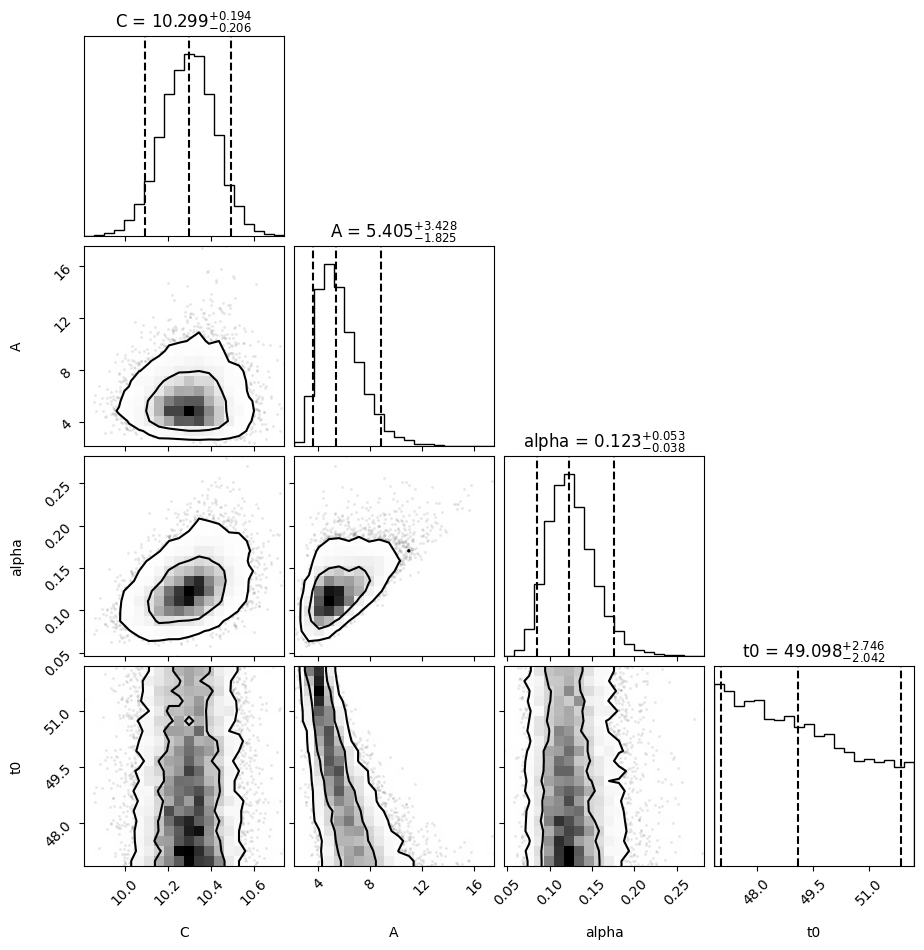

In [ ]:
import corner

burn = 5000

# calculate the autocorreletion lenght
autocor_time_data = sampler.get_autocorr_time()
print ("autocorrelation time: ", autocor_time_data)
thin = int(np.mean(autocor_time_data)) #save only the non - correleted samples

# flat of the samples + thinning + burn
flat_samples = sampler.get_chain(discard=burn, thin=thin, flat=True)

labels = ["C", "A", "alpha", "t0"]

# Corner plot with confidence levels at 90%
fig_corner = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], 
                           show_titles=True, quantiles=[0.05, 0.5, 0.95], 
                           title_fmt=".3f", title_kwargs={"fontsize": 12})

print("Parameters with deviations at the 5th and 95th percentiles for a 90% confidence interval.")

# print
for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [5, 50, 95])
    q = np.diff(mcmc)
    print(f"{labels[i]} = {mcmc[1]:.3f} (+{q[1]:.3f}/-{q[0]:.3f})")

se la joint è storta significa che c'è correlazione , se ci penso ha senso che A e t0 siano correlate... se t0 è più piccolo A è maggiore... 
ma cosa significano joint completamente dritte??

Text(0.5, 0, 'step number')

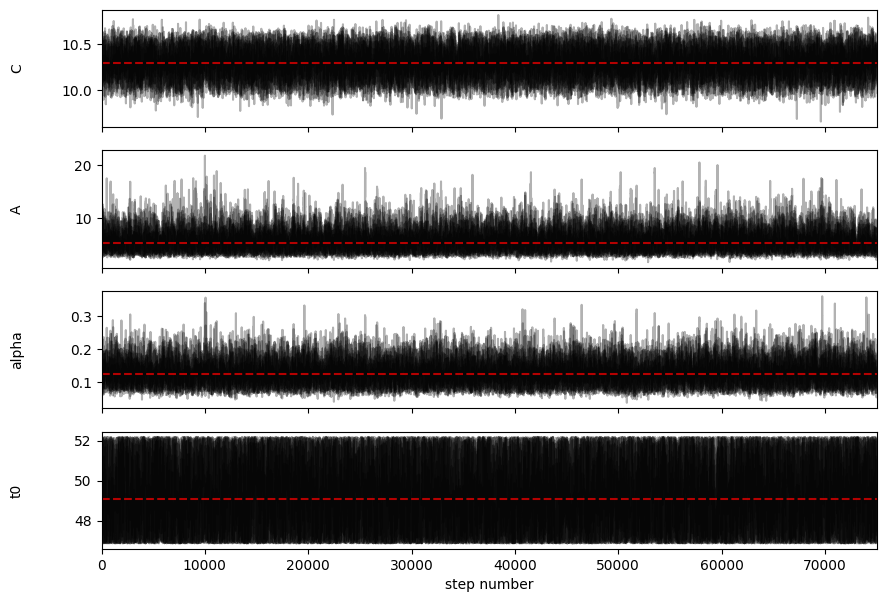

In [19]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=burn) #have I burn it 2 times? No. each time I remove the fist burn
labels = ["C","A", "alpha", "t0"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)  #Per ogni parametro plotto l’evoluzione di tutti i walker
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    median = np.median(flat_samples[:, i])
    ax.axhline(median, color="red", linestyle="--", alpha=0.7)
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

=== Parameters compare ===
emcee:               C=10.297, A=5.407, alpha=0.122, t0=49.090
curve_fit:           C=10.298, A=3.707, alpha=0.117, t0=52.185


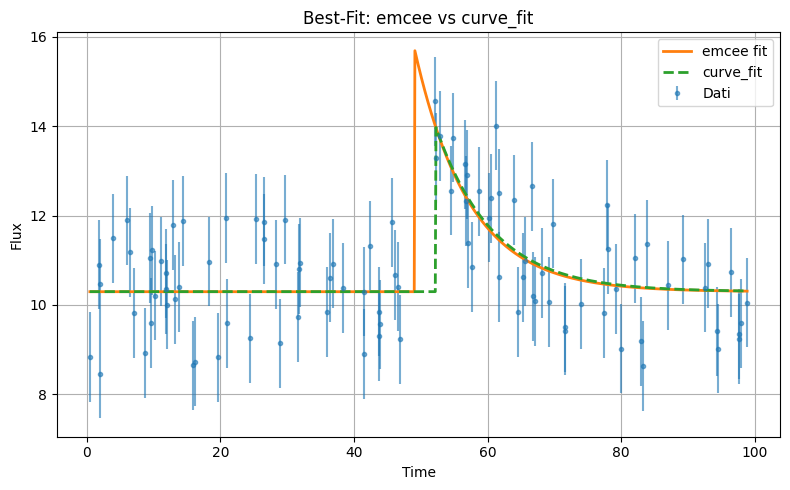

In [20]:
from scipy.optimize import curve_fit

def model_curve_fit(t, C, A, alpha, t0):
    return np.where(t < t0,
                    C,
                    C + A * np.exp(-alpha * (t - t0)))

# emcee median
samples = sampler.get_chain(flat=True)
C_emcee, A_emcee, alpha_emcee, t0_emcee = np.median(samples, axis=0)

# === curve_fit ===
popt, pcov = curve_fit(model_curve_fit, time_data, flux, sigma=err, p0=[C0, A0, alpha0, t0_init])
C_cf, A_cf, alpha_cf, t0_cf = popt

# === Comparison ===
print("=== Parameters compare ===")
print(f"emcee:               C={C_emcee:.3f}, A={A_emcee:.3f}, alpha={alpha_emcee:.3f}, t0={t0_emcee:.3f}")
print(f"curve_fit:           C={C_cf:.3f}, A={A_cf:.3f}, alpha={alpha_cf:.3f}, t0={t0_cf:.3f}")

# === Plot ===
t_fit = np.linspace(time_data.min(), time_data.max(), 1000)
flux_emcee = model_curve_fit(t_fit, C_emcee, A_emcee, alpha_emcee, t0_emcee)
flux_cf  = model_curve_fit(t_fit, C_cf, A_cf, alpha_cf, t0_cf)

plt.figure(figsize=(8, 5))
plt.errorbar(time_data, flux, yerr=err, fmt='.', label='Dati', alpha=0.6)
plt.plot(t_fit, flux_emcee ,'-', lw=2, label='emcee fit', c='C1')
plt.plot(t_fit, flux_cf, '--', lw=2, label='curve_fit', c='C2')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Best-Fit: emcee vs curve_fit")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


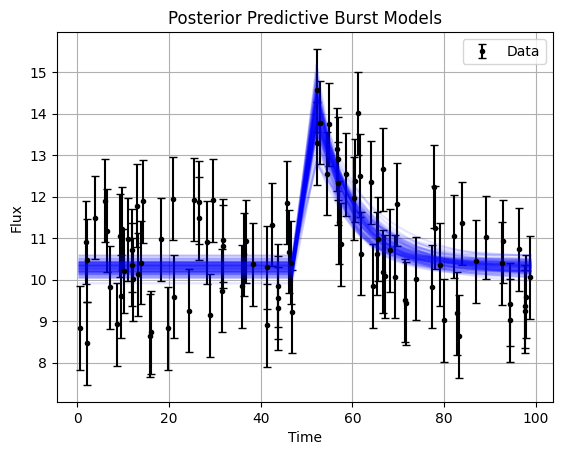

In [ ]:
# Extract 100 random samples from the posterior
idx = np.random.choice(len(flat_samples), size=100, replace=False)
sample = flat_samples[idx]

# Plot data with error bars
plt.errorbar(time_data, flux, yerr=err, fmt='.', color='black', label='Data', capsize=3)

# Plot the 100 models generated from the posterior parameters
for theta in sample:
    plt.plot(time_data, model(time_data, theta), color='blue', alpha=0.1)

plt.xlabel("Time")
plt.ylabel("Flux")
plt.title("Posterior Predictive Burst Models")
plt.legend()
plt.grid(True)
plt.show()

#PERCHè è STORTO???
